# Réseau de neurones à deux couches cachées

Pour cet exercice, vous devez coder en partie un réseau de neurones pleinenement connecté et tester ses performances sur la base de données CIFAR-10.

In [10]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

from ift725.classifiers.two_layer_neural_net import TwoLayerNeuralNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Nous utiliseraons la classe `TwoLayerNeuralNet` dans le fichier `ift725/classifiers/two_layer_neural_net.py` pour entraîner et tester le réseau de neurones. Les paramètres du réseau sont stockés dans la variable dictionnaire `self.params` dont les clés sont les noms des paramètres et les valeurs sont des tableaux numpy. Ci-après est un example jouet (modèle et données) qu'on utilisera pour tester le code.

In [11]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
  np.random.seed(0)
  return TwoLayerNeuralNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
  np.random.seed(1)
  X = 10 * np.random.randn(num_inputs, input_size)
  y = np.array([0, 1, 2, 2, 1])
  return X, y

net = init_toy_model()
X, y = init_toy_data()

# Propagation avant et calcul des scores de classes

Dans le fichier `ift725/classifiers/two_layer_neural_net.py` il y a une méthode nommée `loss`. Cette fonction est très similaire aux fonctions de pertes que vous avez codé aux excercices précédents. 

Ici vous devez coder la propagation avant du réseau afin de calculer le score de chaque classe.

**NOTE:** Utilisez la fonction d'activation **ReLU**.

In [12]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.680272093239262e-08


# Propagation avant : calcul de la perte (loss)
Même fonction, maintenant implanter la perte (entropie croisée) + régularisation.

In [13]:
loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 1.3417187305415879

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
2.220446049250313e-16


# Rétro-propagation
Coder le reste de la fonction `loss(.)`. Vous devrez ainsi coder le gradient de la loss par rapport aux variables `W1`, `b1`, `W2`, et `b2`. À noter que si votre propagation avant fonctionne, vous pourrez tester vos gradients grâce à l'approximation numérique du gradient


# Question 1 :

Avant de commencer à coder, donnez l'équation mathématique du gradient de la perte par rapport aux paramètres `W1`, `W2`, `b1` et `b2` et ce, considérant que une mini-batch de N données contenue dans le tableau 

$$X \in R^{N\times d}$$

où d est la dimensionnalité des données.  Votre réponse doit être linéarisée et donc ne contenir aucune boucle for.


**Votre Réponse:** <br>
$$dW_1 = X^T.(f.W_2^T) $$ 

$$dW_2 = a_1^T.f $$ 

$$db_1 = \sum (f.W_2^T) $$

$$db_2 = \sum f $$


In [14]:
from ift725.gradient_check import evaluate_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.1)

# these should all be less than 1e-8 or so
for param_name in grads:
  f = lambda W: net.loss(X, y, reg=0.1)[0]
  param_grad_num = evaluate_numerical_gradient(f, net.params[param_name], verbose=False)
  print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 3.561318e-09
W2 max relative error: 3.440708e-09
b1 max relative error: 2.738421e-09
b2 max relative error: 4.447677e-11


# Entraînement
Pour entraîner le réseau, nous utiliserons SGD tout comme pour les exercices précédents. Voir la fonction `train`  et remplir les section `TODO`. Vous devez également coder la fonction `predict` car SGD prédict périodiquement des résultats afin de mesurer l'évolution de la justesse (accuracy) au fil du temps.

La cellule suivante vous permet d'entraîner le réseau sur des données jouets et obtenir d'excellents résultats.

Final training loss:  0.00529847865146424


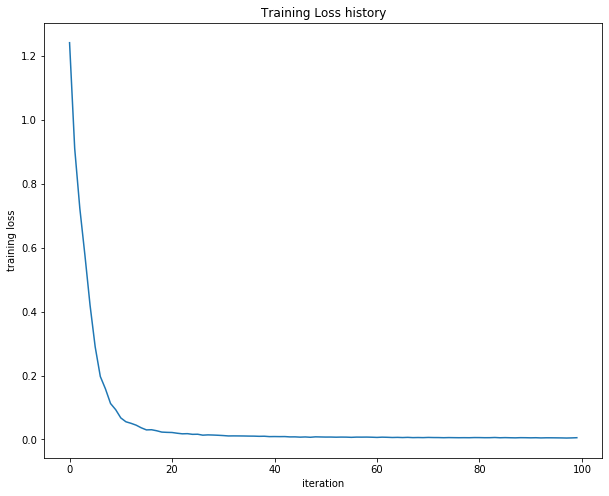

In [15]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=1e-5,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Charger les images 
Testons maintenant les performances du réseau sur une vraie base de données: **CIFAR-10**.

In [16]:
from ift725.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'ift725/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Entraîner le réseau
Pour entraîner le réseau, utilisez SGD avec momentum.  De plus, après chaque epoch, réduisez le taux d'apprentissage (learning_rate) en le multiplicant par le taux de décroissance (learning_rate_decay).

In [21]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNeuralNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=3000, batch_size=200,
            learning_rate=8e-5, learning_rate_decay=0.98,
            reg=0.5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 3000: loss 2.303320
iteration 100 / 3000: loss 2.302976
iteration 200 / 3000: loss 2.300809
iteration 300 / 3000: loss 2.286732
iteration 400 / 3000: loss 2.249063
iteration 500 / 3000: loss 2.168393
iteration 600 / 3000: loss 2.214421
iteration 700 / 3000: loss 2.056886
iteration 800 / 3000: loss 2.065091
iteration 900 / 3000: loss 2.063828
iteration 1000 / 3000: loss 2.072796
iteration 1100 / 3000: loss 2.037303
iteration 1200 / 3000: loss 1.877034
iteration 1300 / 3000: loss 1.833764
iteration 1400 / 3000: loss 1.938518
iteration 1500 / 3000: loss 1.816822
iteration 1600 / 3000: loss 1.889106
iteration 1700 / 3000: loss 1.876887
iteration 1800 / 3000: loss 1.857819
iteration 1900 / 3000: loss 1.837942
iteration 2000 / 3000: loss 1.880415
iteration 2100 / 3000: loss 1.644815
iteration 2200 / 3000: loss 1.705897
iteration 2300 / 3000: loss 1.835432
iteration 2400 / 3000: loss 1.867823
iteration 2500 / 3000: loss 1.806950
iteration 2600 / 3000: loss 1.723442
iteration 270

# Visualiser l'entraînement
Avec les paramètres par défaut, vous devriez obtenir une justesse infériure à 0.4 sur l'ensemble de validation. 

Pour visualiser les résultats de l'entraînement, il est courant d'afficher les courbes d'apprentissage ainsi que les poids de la première couche.

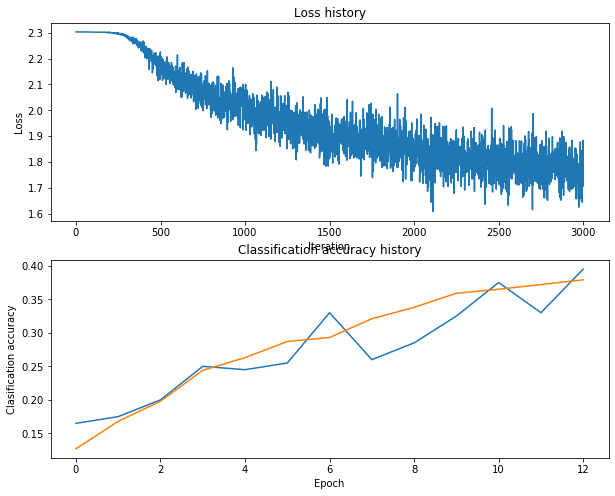

In [22]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

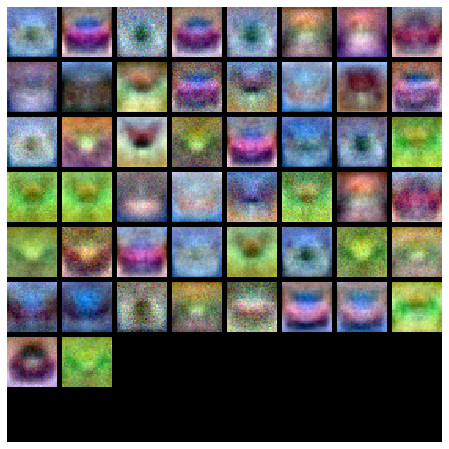

In [23]:
from ift725.vis_utils import visualize_as_grid

# Visualize the weights of the network

def show_net_weights(net):
  W1 = net.params['W1']
  W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
  plt.imshow(visualize_as_grid(W1, padding=3).astype('uint8'))
  plt.gca().axis('off')
  plt.show()

show_net_weights(net)

# Ajustement de hyperparamètres

Dans la prochaine cellule, vous devez rédiger du code permettant de choisir les hyper-paramètres (learning_rate et regularization) qui permettent d'atteindre une justesse de validation d'environ 0.5.

In [24]:
best_net = None # store the best model into this 
best_acc = -1
best_stats = None
results = {}

#################################################################################
# TODO: Ajustez les hyper-paramètres en utilisant les données de validations.   #
#  Stockez le meilleur modèle de réseau de neurones dans la variable "best_net".#
#                                                                               #
# Pour vous aider à déboguer votre réseau, il peut être utile d'utiliser une    #
# visualisation similaire à celle utilisée juste avant; ces visualisations      #
# auront une différence qualitative différente de celle vu plus avant pour le   #
# réseau faiblement ajusté.                                                     #
#                                                                               #
# Ajuster les hyper-paramètres manuellement peut être amusant, mais vous devriez#
# trouver utile d'écrire du code qui balai l'ensemble des combinaisons          #
# d'hyper-paramètres possibles de façon automatique comme vous avez fait lors   #
# de l'exercice précédent.                                                      #
#################################################################################
from itertools import product as itprod

lr_list = 10 ** np.linspace(-4, -2, 4)
reg_list = 10 ** np.linspace(-7, -1, 4)
hs = 200
ni = 3000

best_params = None

for lr, reg in itprod(lr_list, reg_list):
    net = TwoLayerNeuralNet(32 * 32 * 3, hs, 10)
    stats = net.train(X_train, y_train, X_val, y_val, num_iters=ni, batch_size=49,
                      learning_rate=lr, reg=reg, verbose=False)

    # computing training and validation accuracies
    train_acc = (net.predict(X_train) == y_train).mean() 
    valid_acc = (net.predict(X_val) == y_val).mean()
    params = (lr, reg, hs, ni)
    results[params] = valid_acc
    if valid_acc > best_acc:
        best_acc = valid_acc
        best_net = net
        best_stats = stats
        best_params = params
    print('{} -- Tacc: {:>5.3f}  Vacc: {:>5.3f}'.format(params, train_acc, valid_acc))
    
#################################################################################
#                              FIN DE VOTRE CODE                                #
#################################################################################

(0.0001, 1e-07, 200, 3000) -- Tacc: 0.429  Vacc: 0.443
(0.0001, 1e-05, 200, 3000) -- Tacc: 0.423  Vacc: 0.417
(0.0001, 0.001, 200, 3000) -- Tacc: 0.430  Vacc: 0.430
(0.0001, 0.1, 200, 3000) -- Tacc: 0.422  Vacc: 0.428
(0.00046415888336127773, 1e-07, 200, 3000) -- Tacc: 0.524  Vacc: 0.490
(0.00046415888336127773, 1e-05, 200, 3000) -- Tacc: 0.516  Vacc: 0.493
(0.00046415888336127773, 0.001, 200, 3000) -- Tacc: 0.516  Vacc: 0.475
(0.00046415888336127773, 0.1, 200, 3000) -- Tacc: 0.510  Vacc: 0.475
(0.002154434690031882, 1e-07, 200, 3000) -- Tacc: 0.328  Vacc: 0.334
(0.002154434690031882, 1e-05, 200, 3000) -- Tacc: 0.374  Vacc: 0.362
(0.002154434690031882, 0.001, 200, 3000) -- Tacc: 0.313  Vacc: 0.307
(0.002154434690031882, 0.1, 200, 3000) -- Tacc: 0.348  Vacc: 0.331
(0.01, 1e-07, 200, 3000) -- Tacc: 0.100  Vacc: 0.087
(0.01, 1e-05, 200, 3000) -- Tacc: 0.100  Vacc: 0.087
(0.01, 0.001, 200, 3000) -- Tacc: 0.100  Vacc: 0.087
(0.01, 0.1, 200, 3000) -- Tacc: 0.100  Vacc: 0.087


C:\Users\Agath\OneDrive\Documents\SemestreHiver2020\IFT725\TP1\GIT\TP1-IFT725\prog\ift725\classifiers\two_layer_neural_net.py:110: RuntimeWarning: divide by zero encountered in log
  loss = -np.log(softmax[range(N), y])
C:\Users\Agath\OneDrive\Documents\SemestreHiver2020\IFT725\TP1\GIT\TP1-IFT725\prog\ift725\classifiers\two_layer_neural_net.py:107: RuntimeWarning: overflow encountered in exp
  exp_scores = np.exp(scores)
C:\Users\Agath\OneDrive\Documents\SemestreHiver2020\IFT725\TP1\GIT\TP1-IFT725\prog\ift725\classifiers\two_layer_neural_net.py:108: RuntimeWarning: invalid value encountered in true_divide
  softmax = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
C:\Users\Agath\OneDrive\Documents\SemestreHiver2020\IFT725\TP1\GIT\TP1-IFT725\prog\ift725\classifiers\two_layer_neural_net.py:142: RuntimeWarning: invalid value encountered in less_equal
  f1[scores_1 <= 0] = 0


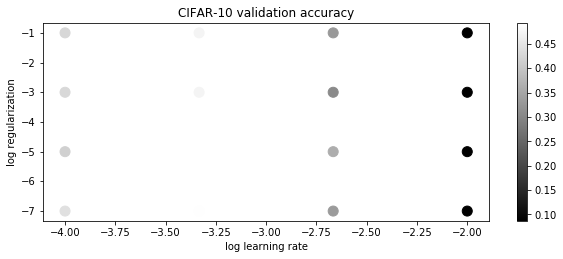

Best val acc: 0.493


In [25]:
# Visualize the cross-validation results
import math
marker_size = 100
x_scatter, x_label = [np.log10(x[0]) for x in results], 'log learning rate'
y_scatter, y_label = [np.log10(x[1]) for x in results], 'log regularization'

# plot validation accuracy
colors = [results[x] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('CIFAR-10 validation accuracy')
plt.show()

print('Best val acc:', best_acc)

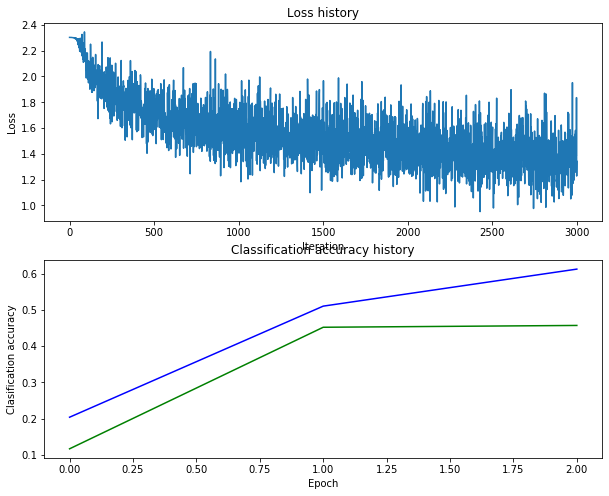

In [26]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train', color='blue')
plt.plot(best_stats['val_acc_history'], label='val', color='green')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

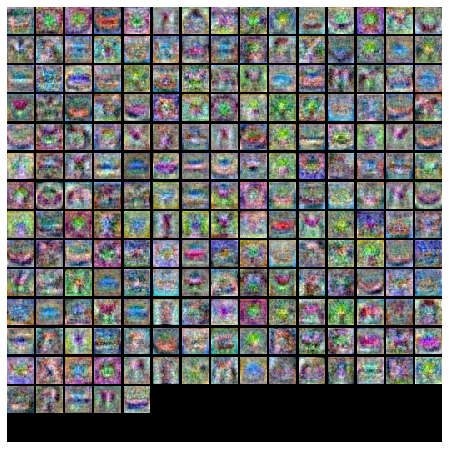

In [27]:
# visualize the weights of the best network
show_net_weights(best_net)

# Exécution du modèle sur les données test
Une fois terminé, il est temps de mesurer la justesse de notre modèle sur les données test.  Vous devriez obtenir une justesse d'environ 0.45

In [28]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.475


# Question 2
(a) Donnez en octets la quantité de mémoire requise pour stocker les paramètres de votre réseau.

(b) Donnez en octets la quantité de mémoire requise pour entraîner votre réseau lorsque vous utilisez des images CIFAR et une taille de batch de 10.

# réponse :
(a) Les données d'entrées sont telles que $32*32*3 = 3072$. On ajoute 1 pour le biais, la couche fully connected 1 est donc de taille $1*3073$. Le nombre de paramètres nécessaires à ce stade du réseau est de $(32*32*3+1)*3073 = 9.443.329$ paramètres.
La couche fully connected 2 est donc de même taille $1*3073$. Le nombre de paramètres nécessaires pour son traitement est de $3073*10=30.730$ paramètres car la sortie du réseau est de $10$ classes.
Au total, on génére $9.443.329 + 30730 = 9.474.059$ paramètres. Un paramètre étant une valeur float de 32 bits, prenant 4 octets en mémoire, la quantité de mémoire nécessaire pour les paramètres du réseau est de : $9.474.059*4=37,89$ Mo.

(b)Pour une taille de batch X de $10$, la couche fully connected 1 serait telle que $3073*10 = 30.730$. Le nombre de paramètres serait $30.730 * 30.730 = 944.332.900$ paramètres. Pour la couche fully connected 2 on aurait $30.730*10=307.300$ paramètres.
Au total, on génère $944.332.900+307.300=944.640.200$ paramètres. Pour la mémoire, on aurait donc besoin de 3,77 Go.